### Import libraries and scripts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

### Initial Data Preparation steps

In [2]:

data_300 = pd.read_csv("../data/DatosGaba_300.csv",sep=",")
#data_200 = pd.read_csv("../data/DatosGaba_200.csv",sep=",")


In [3]:
data = data_300

Añadir columnas con la codificación circular para el día del año y día de la semana

In [4]:
import numpy as np
import pandas as pd

# Concatenar las columnas 'an', 'mes', 'dia' para crear una fecha
data['fecha'] = pd.to_datetime(data['an'].astype(str) + '-' + data['mes'].astype(str) + '-' + data['dia'].astype(str), format='%Y-%m-%d', errors='coerce')

# Extraer el día del año (1-365)
data['day_of_year'] = data['fecha'].dt.dayofyear

# Aplicar la codificación circular para el día del año (Seno y Coseno)
data['day_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365.0)
data['day_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365.0)

# Extraer el día de la semana (0-6, lunes a domingo)
data['day_of_week'] = data['fecha'].dt.dayofweek

# Aplicar la codificación circular para el día de la semana (Seno y Coseno)
data['day_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7.0)
data['day_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7.0)

# Verifica el resultado
data[['an', 'mes', 'dia', 'day_of_year', 'day_year_sin', 'day_year_cos', 'day_of_week', 'day_week_sin', 'day_week_cos']].head()


,an,mes,dia,day_of_year,day_year_sin,day_year_cos,day_of_week,day_week_sin,day_week_cos
0,2023,7,1,182,0.008607,-0.999963,5,-0.974928,-0.222521
1,2023,7,2,183,-0.008607,-0.999963,6,-0.781831,0.623490
2,2023,7,3,184,-0.025818,-0.999667,0,0.000000,1.000000
3,2023,7,4,185,-0.043022,-0.999074,1,0.781831,0.623490
4,2023,7,5,186,-0.060213,-0.998186,2,0.974928,-0.222521


In [5]:
len(data.id.unique())

835

In [6]:
print(data.columns)

Index(['id', 'an', 'mes', 'dia', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7',
       'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17',
       'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24', 'fecha', 'day_of_year',
       'day_year_sin', 'day_year_cos', 'day_of_week', 'day_week_sin',
       'day_week_cos'],
      dtype='object')


##  Segmentar usuarios en el conjunto de validación, entrenamiento y test


Split en train, val y test de modo que los datos de cada de un usuario solo caigan en uno de los 3 sets. Los datos de consumo de los usuarios que caigan en el set de test serán de consumos diarios de fechas posteriores a las utilizadas en el entrenamiento y validación de modelos

In [7]:
# Rango de fechas de consumo
min_fecha = data['fecha'].min()
max_fecha = data['fecha'].max()

print(f"Fecha menor: {min_fecha}")
print(f"Fecha mayor: {max_fecha}")

Fecha menor: 2022-05-07 00:00:00
Fecha mayor: 2024-11-10 00:00:00


### Split en fechas

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

def tiene_n_dias_consecutivos(df_usuario, ndias):
    """
    Verifica si un usuario tiene al menos `ndias` consecutivos de consumo.
    """
    fechas = df_usuario['fecha'].sort_values()
    racha_actual, max_racha = 1, 1
    for i in range(1, len(fechas)):
        if (fechas.iloc[i] - fechas.iloc[i-1]).days == 1:
            racha_actual += 1
        else:
            max_racha = max(max_racha, racha_actual)
            racha_actual = 1  # Reinicia la racha
    return max(max_racha, racha_actual) >= ndias

def repartir_usuarios(df, min_dias_train=90, min_dias_val=90, min_dias_test=25):
    """
    Reparte los usuarios en Train, Val y Test asegurando que:
    - Test tiene usuarios con mayoría de datos en 2024 (>80%)
    - Train y Val tienen usuarios con datos hasta 31-12-2023
    """
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Identificar usuarios con mayoría de datos en 2024 (>80% de sus registros en 2024)
    user_year_counts = df.groupby('id')['an'].value_counts(normalize=True).unstack().fillna(0)
    usuarios_test = user_year_counts[user_year_counts[2024] > 0.8].index
    
    df_test = df[df['id'].isin(usuarios_test)]
    df_train_val = df[~df['id'].isin(usuarios_test)]  # Resto para Train/Val
    
    print("Usuarios en Train/Val antes de filtrar por días consecutivos:", df_train_val['id'].nunique())
    print("Usuarios en Test antes de filtrar por días consecutivos:", df_test['id'].nunique())
    
        # Eliminar consumos de 2024 en Train y Val
    df_train_val_filtered = df_train_val[df_train_val['an'] < 2024]
    df_test_filtered = df_test[df_test['an'] >= 2024]
    
    # Filtrar usuarios con suficientes días consecutivos después de limpiar las fechas
    df_train_val_filtered = df_train_val_filtered.groupby('id').filter(lambda x: tiene_n_dias_consecutivos(x, min_dias_train))
    df_test_filtered = df_test_filtered.groupby('id').filter(lambda x: tiene_n_dias_consecutivos(x, min_dias_test))
    
    print("Usuarios en Train/Val después de filtrar:", df_train_val_filtered['id'].nunique())
    print("Usuarios en Test después de filtrar:", df_test_filtered['id'].nunique())
    
    # División en Train y Val (80%-20%)
    train_users, val_users = train_test_split(
        df_train_val_filtered['id'].unique(), test_size=0.2, random_state=42
    )
    
    df_train_filtered = df_train_val_filtered[df_train_val_filtered['id'].isin(train_users)]
    df_val_filtered = df_train_val_filtered[df_train_val_filtered['id'].isin(val_users)]
    
    return df_train_filtered, df_val_filtered, df_test_filtered

df_train, df_val, df_test = repartir_usuarios(data)

# Mostrar tamaños finales
print("Train:", df_train['id'].nunique(), "usuarios")
print("Val:", df_val['id'].nunique(), "usuarios")
print("Test:", df_test['id'].nunique(), "usuarios")


Usuarios en Train/Val antes de filtrar por días consecutivos: 733
Usuarios en Test antes de filtrar por días consecutivos: 102
Usuarios en Train/Val después de filtrar: 713
Usuarios en Test después de filtrar: 102
Train: 570 usuarios
Val: 143 usuarios
Test: 102 usuarios


In [9]:
df_train_filtered = df_train
df_val_filtered = df_val
df_test_filtered = df_test

In [10]:
# Verificar que no haya usuarios repetidos entre los tres conjuntos
usuarios_train = set(df_train_filtered['id'])
usuarios_val = set(df_val_filtered['id'])
usuarios_test = set(df_test_filtered['id'])

# Comprobar si hay intersección entre los conjuntos
interseccion_train_val = usuarios_train.intersection(usuarios_val)
interseccion_train_test = usuarios_train.intersection(usuarios_test)
interseccion_val_test = usuarios_val.intersection(usuarios_test)

# Mostrar los resultados
print(f"Usuarios repetidos entre Train y Validation: {len(interseccion_train_val)}")
print(f"Usuarios repetidos entre Train y Test: {len(interseccion_train_test)}")
print(f"Usuarios repetidos entre Validation y Test: {len(interseccion_val_test)}")

# También puedes verificar si no hay intersección en general
usuarios_totales = usuarios_train.union(usuarios_val).union(usuarios_test)
print(f"Total de usuarios únicos: {len(usuarios_totales)}")
print(f"Usuarios en Train + Validation + Test: {len(usuarios_train) + len(usuarios_val) + len(usuarios_test)}")


Usuarios repetidos entre Train y Validation: 0
Usuarios repetidos entre Train y Test: 0
Usuarios repetidos entre Validation y Test: 0
Total de usuarios únicos: 815
Usuarios en Train + Validation + Test: 815


## Distribución de los datos 


🔹 **Estadísticas descriptivas de consumo:**
              count      mean       std  min    25%    50%    75%     max
Conjunto                                                                 
Test       739176.0  0.387543  0.980805  0.0  0.023  0.110  0.279  17.890
Train     3433392.0  0.289262  0.605770  0.0  0.034  0.108  0.261  18.302
Val        886656.0  0.229132  0.485543  0.0  0.025  0.078  0.216  19.500


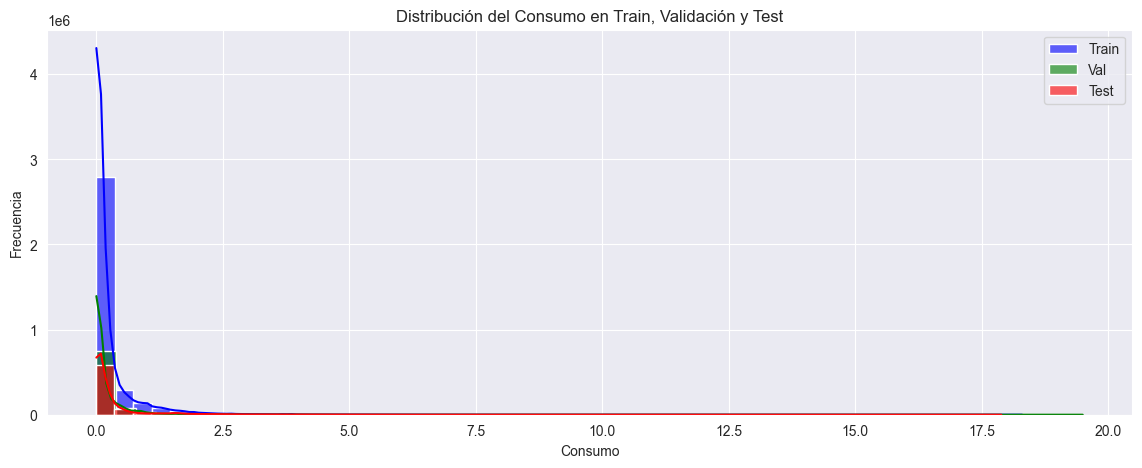

/var/folders/py/s4nbb_h16932q2nnlw598gjm0000gn/T/ipykernel_6510/3922865164.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Conjunto", y="Consumo", data=df_comparacion, palette={"Train": "blue", "Val": "green", "Test": "red"})


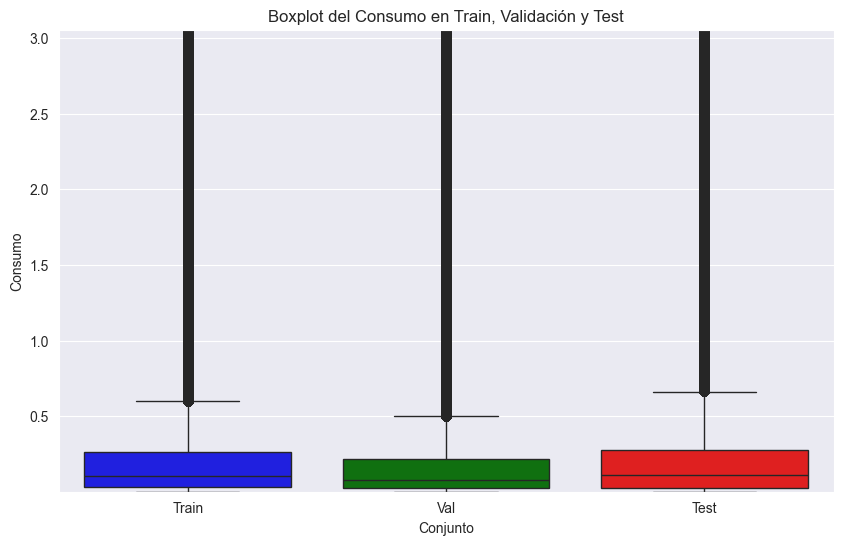

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Asegurar que las columnas de consumo se seleccionan correctamente
col_inicio_consumo = 4  # La primera columna de consumo
num_horas = 24  # Número de horas de consumo
col_fin_consumo = col_inicio_consumo + num_horas  # Última columna de consumo

# 📌 Seleccionar solo las columnas de consumo y aplanar valores
consumo_train = df_train_filtered.iloc[:, col_inicio_consumo:col_fin_consumo].values.flatten()
consumo_val = df_val_filtered.iloc[:, col_inicio_consumo:col_fin_consumo].values.flatten()
consumo_test = df_test_filtered.iloc[:, col_inicio_consumo:col_fin_consumo].values.flatten()

# 📌 Crear DataFrame para comparar distribuciones
df_comparacion = pd.DataFrame({
    'Conjunto': (['Train'] * len(consumo_train)) + (['Val'] * len(consumo_val)) + (['Test'] * len(consumo_test)),
    'Consumo': list(consumo_train) + list(consumo_val) + list(consumo_test)
})

# 📌 Calcular estadísticas descriptivas
stats = df_comparacion.groupby("Conjunto")["Consumo"].describe()
print("\n🔹 **Estadísticas descriptivas de consumo:**")
print(stats)

# 📌 Histogramas de consumo
plt.figure(figsize=(14, 5))
sns.histplot(consumo_train, bins=50, kde=True, color="blue", label="Train", alpha=0.6)
sns.histplot(consumo_val, bins=50, kde=True, color="green", label="Val", alpha=0.6)
sns.histplot(consumo_test, bins=50, kde=True, color="red", label="Test", alpha=0.6)
plt.xlabel("Consumo")
plt.ylabel("Frecuencia")
plt.legend()
plt.title("Distribución del Consumo en Train, Validación y Test")
plt.show()

# 📌 Boxplots para detectar sesgos
plt.figure(figsize=(10, 6))
sns.boxplot(x="Conjunto", y="Consumo", data=df_comparacion, palette={"Train": "blue", "Val": "green", "Test": "red"})
plt.ylim(df_comparacion["Consumo"].quantile(0.01), df_comparacion["Consumo"].quantile(0.99))  # Eliminar valores extremos
plt.title("Boxplot del Consumo en Train, Validación y Test")
plt.show()


In [111]:
# Mostrar para cada usuario el númerod e días consecutivos fecha ini y fin
train_data_sorted = df_train_filtered.sort_values(by=['id', 'fecha'])
val_data_sorted = df_val_filtered.sort_values(by=['id', 'fecha'])
test_data_sorted = df_test_filtered.sort_values(by=['id', 'fecha'])

# Función para calcular días consecutivos y fechas iniciales y finales
def calcular_dias_consecutivos(df):
    # Calcular la diferencia de fechas entre consecutivas
    df['fecha_diff'] = df.groupby('id')['fecha'].diff().dt.days
    # Identificar las secuencias consecutivas (donde la diferencia de días es diferente de 1)
    df['nuevo_grupo'] = (df['fecha_diff'] != 1).cumsum()

    # Agrupar por id y grupo, y calcular el número de días consecutivos y las fechas inicial y final
    resultado = df.groupby(['id', 'nuevo_grupo']).agg(
        dias_consecutivos=('fecha', 'size'),
        fecha_inicial=('fecha', 'min'),
        fecha_final=('fecha', 'max')
    ).reset_index(drop=False)

    # Eliminar el grupo de días consecutivos con diferencia no consecutiva (cuando días es 1)
    return resultado[['id', 'dias_consecutivos', 'fecha_inicial', 'fecha_final']]

# Calcular los días consecutivos para cada conjunto
train_consecutivos = calcular_dias_consecutivos(train_data_sorted)
val_consecutivos = calcular_dias_consecutivos(val_data_sorted)
test_consecutivos = calcular_dias_consecutivos(test_data_sorted)

# Mostrar las tablas para cada conjunto
print("\nDías consecutivos en Train:")
print(train_consecutivos)

print("\nDías consecutivos en Validation:")
print(val_consecutivos)


print("\nDías consecutivos en Test:")
print(test_consecutivos)




Días consecutivos en Train:
       id  dias_consecutivos fecha_inicial fecha_final
0       8                184    2023-07-01  2023-12-31
1      10                604    2022-05-07  2023-12-31
2      13                603    2022-05-08  2023-12-31
3      14                184    2023-07-01  2023-12-31
4      15                503    2022-06-03  2023-10-18
..    ...                ...           ...         ...
566  2012                 96    2023-09-27  2023-12-31
567  2026                 91    2023-10-02  2023-12-31
568  2031                 91    2023-10-02  2023-12-31
569  2033                 91    2023-10-02  2023-12-31
570  2034                 91    2023-10-02  2023-12-31

[571 rows x 4 columns]

Días consecutivos en Validation:
       id  dias_consecutivos fecha_inicial fecha_final
0      12                184    2023-07-01  2023-12-31
1      17                571    2022-06-09  2023-12-31
2      31                597    2022-05-14  2023-12-31
3      86                570    2

## Preparación de las matrices A, GT, cos y sin

In [12]:
def create_datasets(df, output_prefix):
    
    datasets = {
        'A': [], 'cos_day_week': [], 'sin_day_week': [],
        'cos_day_year': [], 'sin_day_year': [], 'GT': []
    }

    # Iterar por cada usuario
    for user_id, user_df in df.groupby('id'):
        user_df = user_df.sort_values(by='fecha').reset_index(drop=True)

        # Deslizar la ventana de 24 días
        for i in range(len(user_df) - 24):
            window = user_df.iloc[i:i + 24]
            next_day = user_df.iloc[i + 24]

            # Dataset A: consumo de 24 días x 24 horas
            datasets['A'].append(window[[f'h{j}' for j in range(1, 25)]].values)

            # Datasets de codificación circular
            datasets['cos_day_week'].append(np.tile(window['day_week_cos'].values.reshape(-1, 1), (1, 24)))
            datasets['sin_day_week'].append(np.tile(window['day_week_sin'].values.reshape(-1, 1), (1, 24)))
            datasets['cos_day_year'].append(np.tile(window['day_year_cos'].values.reshape(-1, 1), (1, 24)))
            datasets['sin_day_year'].append(np.tile(window['day_year_sin'].values.reshape(-1, 1), (1, 24)))

            # GT: consumo del día siguiente
            datasets['GT'].append(next_day[[f'h{j}' for j in range(1, 25)]].values)

    # Convertir a numpy arrays
    for key in datasets:
        datasets[key] = np.array(datasets[key])
        np.save(f"../data/{output_prefix}_{key}.npy", datasets[key])
        print(f"Guardado {output_prefix}_{key}.npy con forma {datasets[key].shape}")

# Cargar tu dataset y aplicar la función
# Supongamos que train, val y test son DataFrames
create_datasets(df_train_filtered, 'train')
create_datasets(df_val_filtered, 'val')
create_datasets(df_test_filtered, 'test')


Guardado train_A.npy con forma (129378, 24, 24)
Guardado train_cos_day_week.npy con forma (129378, 24, 24)
Guardado train_sin_day_week.npy con forma (129378, 24, 24)
Guardado train_cos_day_year.npy con forma (129378, 24, 24)
Guardado train_sin_day_year.npy con forma (129378, 24, 24)
Guardado train_GT.npy con forma (129378, 24)
Guardado val_A.npy con forma (33512, 24, 24)
Guardado val_cos_day_week.npy con forma (33512, 24, 24)
Guardado val_sin_day_week.npy con forma (33512, 24, 24)
Guardado val_cos_day_year.npy con forma (33512, 24, 24)
Guardado val_sin_day_year.npy con forma (33512, 24, 24)
Guardado val_GT.npy con forma (33512, 24)
Guardado test_A.npy con forma (28351, 24, 24)
Guardado test_cos_day_week.npy con forma (28351, 24, 24)
Guardado test_sin_day_week.npy con forma (28351, 24, 24)
Guardado test_cos_day_year.npy con forma (28351, 24, 24)
Guardado test_sin_day_year.npy con forma (28351, 24, 24)
Guardado test_GT.npy con forma (28351, 24)


## Carga de las matrices np

In [12]:

# Cargar datasets con allow_pickle=True para train, val y test
def load_datasets(prefix, normalized=False):
    suffix = "_norm" if normalized else ""
    A = np.load(f"../data/{prefix}_A{suffix}.npy", allow_pickle=True)
    cos_day_week = np.load(f"../data/{prefix}_cos_day_week.npy", allow_pickle=True)
    sin_day_week = np.load(f"../data/{prefix}_sin_day_week.npy", allow_pickle=True)
    cos_day_year = np.load(f"../data/{prefix}_cos_day_year.npy", allow_pickle=True)
    sin_day_year = np.load(f"../data/{prefix}_sin_day_year.npy", allow_pickle=True)
    GT = np.load(f"../data/{prefix}_GT{suffix}.npy", allow_pickle=True)

    print(f"{prefix} shapes:")
    print(f"A shape: {A.shape}")
    print(f"cos_day_week shape: {cos_day_week.shape}")
    print(f"sin_day_week shape: {sin_day_week.shape}")
    print(f"cos_day_year shape: {cos_day_year.shape}")
    print(f"sin_day_year shape: {sin_day_year.shape}")
    print(f"GT shape: {GT.shape}")

    return A, cos_day_week, sin_day_week, cos_day_year, sin_day_year, GT

# Cargar los datasets
A_train, cos_day_week_train, sin_day_week_train, cos_day_year_train, sin_day_year_train, GT_train = load_datasets("train")
A_val, cos_day_week_val, sin_day_week_val, cos_day_year_val, sin_day_year_val, GT_val = load_datasets("val")
A_test, cos_day_week_test, sin_day_week_test, cos_day_year_test, sin_day_year_test, GT_test = load_datasets("test")



train shapes:
A shape: (129378, 24, 24)
cos_day_week shape: (129378, 24, 24)
sin_day_week shape: (129378, 24, 24)
cos_day_year shape: (129378, 24, 24)
sin_day_year shape: (129378, 24, 24)
GT shape: (129378, 24)
val shapes:
A shape: (33512, 24, 24)
cos_day_week shape: (33512, 24, 24)
sin_day_week shape: (33512, 24, 24)
cos_day_year shape: (33512, 24, 24)
sin_day_year shape: (33512, 24, 24)
GT shape: (33512, 24)
test shapes:
A shape: (28351, 24, 24)
cos_day_week shape: (28351, 24, 24)
sin_day_week shape: (28351, 24, 24)
cos_day_year shape: (28351, 24, 24)
sin_day_year shape: (28351, 24, 24)
GT shape: (28351, 24)


# Image example

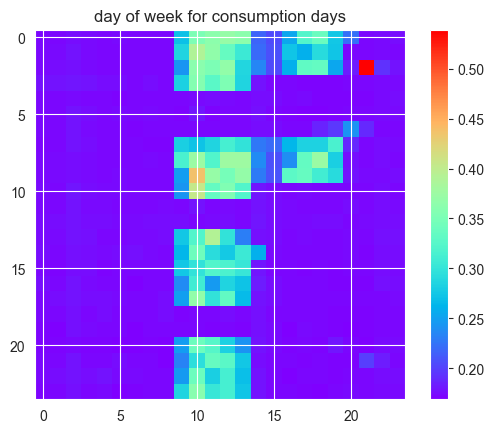

In [5]:
plt.imshow(A_train[233],cmap = 'rainbow')
plt.title("day of week for consumption days")
plt.colorbar()

In [21]:
A_train[233]

array([[0.173, 0.173, 0.175, 0.174, 0.173, 0.174, 0.172, 0.172, 0.173,
        0.271, 0.352, 0.363, 0.371, 0.363, 0.218, 0.205, 0.254, 0.322,
        0.339, 0.275, 0.223, 0.173, 0.174, 0.176],
       [0.172, 0.174, 0.179, 0.174, 0.173, 0.172, 0.172, 0.173, 0.172,
        0.285, 0.39 , 0.366, 0.336, 0.306, 0.22 , 0.207, 0.274, 0.26 ,
        0.291, 0.274, 0.172, 0.172, 0.174, 0.173],
       [0.172, 0.176, 0.177, 0.174, 0.173, 0.172, 0.173, 0.173, 0.172,
        0.244, 0.362, 0.352, 0.368, 0.287, 0.235, 0.205, 0.259, 0.332,
        0.334, 0.254, 0.183, 0.539, 0.193, 0.178],
       [0.177, 0.178, 0.18 , 0.178, 0.176, 0.176, 0.173, 0.176, 0.173,
        0.283, 0.357, 0.327, 0.354, 0.286, 0.178, 0.172, 0.172, 0.171,
        0.171, 0.171, 0.172, 0.172, 0.174, 0.174],
       [0.172, 0.172, 0.174, 0.173, 0.173, 0.171, 0.172, 0.173, 0.172,
        0.173, 0.174, 0.175, 0.174, 0.173, 0.176, 0.176, 0.172, 0.174,
        0.171, 0.171, 0.171, 0.171, 0.174, 0.175],
       [0.173, 0.173, 0.178, 0.175,

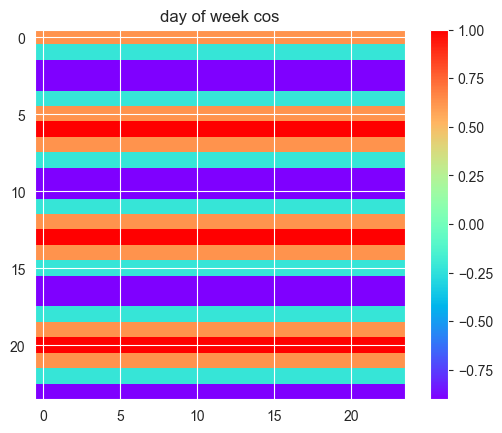

In [22]:
plt.imshow(cos_day_week_train[233],cmap = 'rainbow')
plt.title("day of week cos")
plt.colorbar()

## Normalizar datos de consumo en las matrizes A y GT

In [23]:
from sklearn.preprocessing import MinMaxScaler

# 📌 Obtener el mínimo y máximo común de todos los conjuntos de consumo
global_min = min(A_train.min(), A_val.min(), A_test.min(), GT_train.min(), GT_val.min(), GT_test.min())
global_max = max(A_train.max(), A_val.max(), A_test.max(), GT_train.max(), GT_val.max(), GT_test.max())

# 📌 Crear el escalador para A y GT en el rango [0,1]
scaler_A_GT = MinMaxScaler(feature_range=(-1, 1))
scaler_A_GT.fit([[global_min], [global_max]])  # Ajustar con el mínimo y máximo global

# 📌 Normalizar A y GT en [0,1]
A_train_norm = scaler_A_GT.transform(A_train.reshape(-1, 1)).reshape(A_train.shape)
A_val_norm = scaler_A_GT.transform(A_val.reshape(-1, 1)).reshape(A_val.shape)
A_test_norm = scaler_A_GT.transform(A_test.reshape(-1, 1)).reshape(A_test.shape)

GT_train_norm = scaler_A_GT.transform(GT_train.reshape(-1, 1)).reshape(GT_train.shape)
GT_val_norm = scaler_A_GT.transform(GT_val.reshape(-1, 1)).reshape(GT_val.shape)
GT_test_norm = scaler_A_GT.transform(GT_test.reshape(-1, 1)).reshape(GT_test.shape)


# 📌 Verificar los valores normalizados
print("Nuevo A_train Min-Max:", A_train_norm.min(), A_train_norm.max())
print("Nuevo A_val Min-Max:", A_val_norm.min(), A_val_norm.max())
print("Nuevo A_test Min-Max:", A_test_norm.min(), A_test_norm.max())

print("Nuevo GT_train Min-Max:", GT_train_norm.min(), GT_train_norm.max())
print("Nuevo GT_val Min-Max:", GT_val_norm.min(), GT_val_norm.max())
print("Nuevo GT_test Min-Max:", GT_test_norm.min(), GT_test_norm.max())


Nuevo A_train Min-Max: -1.0 0.877128205128205
Nuevo A_val Min-Max: -1.0 1.0
Nuevo A_test Min-Max: -1.0 0.834871794871795
Nuevo GT_train Min-Max: -1.0 0.877128205128205
Nuevo GT_val Min-Max: -1.0 1.0
Nuevo GT_test Min-Max: -1.0 0.834871794871795


Guardar valores normalizados

In [24]:
np.save(f"../data/train_A_norm.npy", A_train_norm)
np.save(f"../data/val_A_norm.npy", A_val_norm)
np.save(f"../data/test_A_norm.npy", A_test_norm)

np.save(f"../data/train_GT_norm.npy", GT_train_norm)
np.save(f"../data/val_GT_norm", GT_val_norm)
np.save(f"../data/test_GT_norm", GT_test_norm)

Cargar valores normalizados

In [6]:
# Cargar los datasets normalizados
A_train, cos_day_week_train, sin_day_week_train, cos_day_year_train, sin_day_year_train, GT_train= load_datasets("train", normalized=True)
A_val, cos_day_week_val, sin_day_week_val, cos_day_year_val, sin_day_year_val, GT_val = load_datasets("val", normalized=True)
A_test, cos_day_week_test, sin_day_week_test, cos_day_year_test, sin_day_year_test, GT_test = load_datasets("test", normalized=True)


train shapes:
A shape: (129378, 24, 24)
cos_day_week shape: (129378, 24, 24)
sin_day_week shape: (129378, 24, 24)
cos_day_year shape: (129378, 24, 24)
sin_day_year shape: (129378, 24, 24)
GT shape: (129378, 24)
val shapes:
A shape: (33512, 24, 24)
cos_day_week shape: (33512, 24, 24)
sin_day_week shape: (33512, 24, 24)
cos_day_year shape: (33512, 24, 24)
sin_day_year shape: (33512, 24, 24)
GT shape: (33512, 24)
test shapes:
A shape: (28351, 24, 24)
cos_day_week shape: (28351, 24, 24)
sin_day_week shape: (28351, 24, 24)
cos_day_year shape: (28351, 24, 24)
sin_day_year shape: (28351, 24, 24)
GT shape: (28351, 24)


In [10]:

df = pd.DataFrame(GT_test)
df.to_csv('GT_test_normalizado.csv', index=False)

In [11]:
df_test_norm = df

In [9]:
GT_test

array([[-0.99784615, -0.99774359, -0.99764103, ..., -0.99774359,
        -0.99784615, -0.99764103],
       [-0.99784615, -0.99784615, -0.99753846, ..., -0.99774359,
        -0.99794872, -0.99764103],
       [-0.99774359, -0.99784615, -0.99774359, ..., -0.99774359,
        -0.99784615, -0.99774359],
       ...,
       [-0.97128205, -0.96769231, -0.97435897, ..., -0.92430769,
        -0.95538462, -0.96153846],
       [-0.95969231, -0.97507692, -0.97487179, ..., -0.9454359 ,
        -0.95979487, -0.95097436],
       [-0.96912821, -0.97282051, -0.97117949, ..., -0.95805128,
        -0.95733333, -0.96153846]])

In [13]:
GT_test

array([[0.021, 0.022, 0.023, ..., 0.022, 0.021, 0.023],
       [0.021, 0.021, 0.024, ..., 0.022, 0.02, 0.023],
       [0.022, 0.021, 0.022, ..., 0.022, 0.021, 0.022],
       ...,
       [0.28, 0.315, 0.25, ..., 0.738, 0.435, 0.375],
       [0.393, 0.243, 0.245, ..., 0.532, 0.392, 0.478],
       [0.301, 0.265, 0.281, ..., 0.409, 0.416, 0.375]], dtype=object)

In [14]:
df_test = pd.DataFrame(GT_test)
df_test.to_csv('GT_test.csv', index=False)

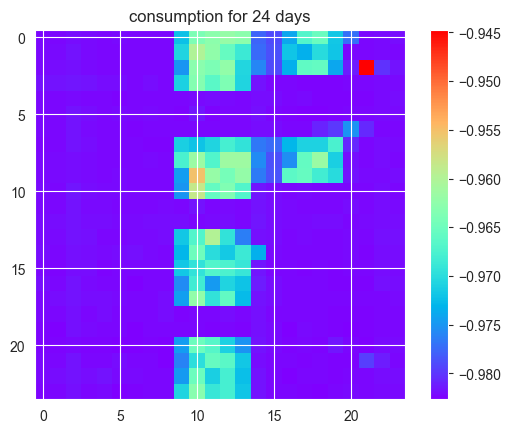

In [5]:
plt.imshow(A_train[233],cmap = 'rainbow')
plt.title("consumption for 24 days")
plt.colorbar()

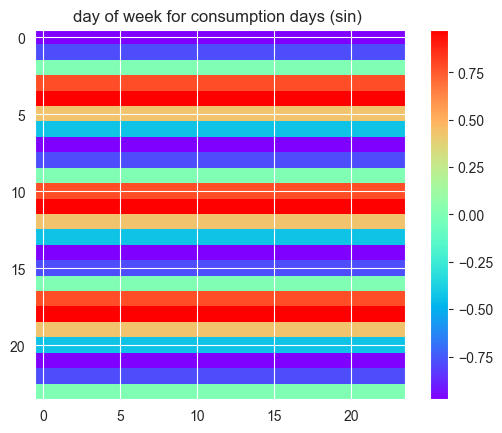

In [6]:
plt.imshow(sin_day_week_train[0],cmap = 'rainbow')
plt.title("day of week for consumption days (sin) ")
plt.colorbar()

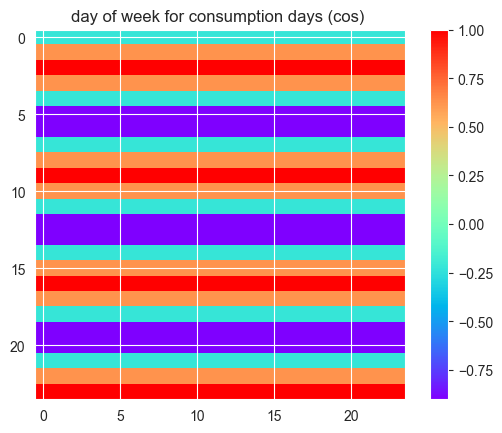

In [8]:
plt.imshow(cos_day_week_train[0],cmap = 'rainbow')
plt.title("day of week for consumption days (cos) ")
plt.colorbar()

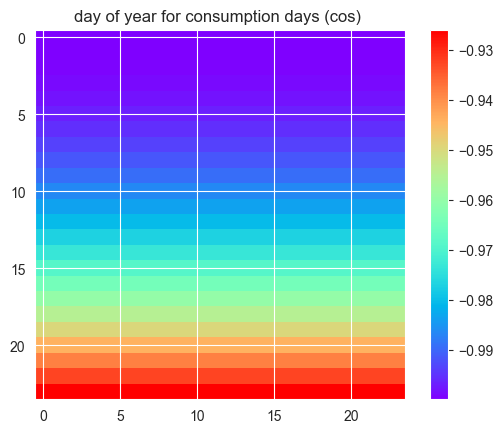

In [9]:
plt.imshow(cos_day_year_train[0],cmap = 'rainbow')
plt.title("day of year for consumption days (cos) ")
plt.colorbar()

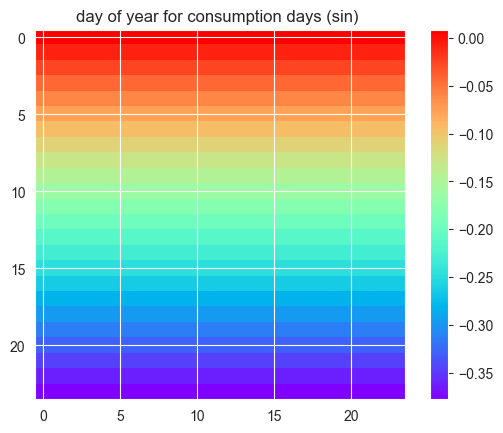

In [10]:
plt.imshow(sin_day_year_train[0],cmap = 'rainbow')
plt.title("day of year for consumption days (sin) ")
plt.colorbar()

## Train Deep Learning model

-- antes de seguir por aquí cargar los datos (ejecutar antes la celda con la función load_datasets())

GPU setting

In [7]:
import aux
aux.set_gpu()


📌 Verificando dispositivos disponibles...
🔹 Todos los dispositivos: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🚀 GPU configurada correctamente con memory growth activado.

🔍 GPU details: {'device_name': 'METAL'}


## Convertir las matrices a estructuras óptimas para la red neuronal

In [8]:
# Crear el dataset de entrada concatenando los 5 canales (A y las codificaciones circulares)
X_train = np.stack([A_train, cos_day_week_train, sin_day_week_train, cos_day_year_train, sin_day_year_train], axis=-1).astype(np.float32)
X_val = np.stack([A_val, cos_day_week_val, sin_day_week_val, cos_day_year_val, sin_day_year_val], axis=-1).astype(np.float32)
X_test = np.stack([A_test, cos_day_week_test, sin_day_week_test, cos_day_year_test, sin_day_year_test], axis=-1).astype(np.float32)

# Verificar dimensiones
print("X_train shape:", X_train.shape)
print("GT_train shape:", GT_train.shape)
print("X_val shape:", X_val.shape)
print("GT_val shape:", GT_val.shape)
print("X_test shape:", X_test.shape)
print("GT_test shape:", GT_test.shape)

# Asegurar que GT tenga la forma correcta
GT_train = GT_train.astype(np.float32).reshape(-1, 24)
GT_val = GT_val.astype(np.float32).reshape(-1, 24)
GT_test = GT_test.astype(np.float32).reshape(-1, 24)

# Convertir a TensorFlow Dataset para eficiencia
def create_tf_dataset(X, Y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 128
train_dataset = create_tf_dataset(X_train, GT_train, batch_size)
val_dataset = create_tf_dataset(X_val, GT_val, batch_size)
test_dataset = create_tf_dataset(X_test, GT_test, batch_size)


X_train shape: (129378, 24, 24, 5)
GT_train shape: (129378, 24)
X_val shape: (33512, 24, 24, 5)
GT_val shape: (33512, 24)
X_test shape: (28351, 24, 24, 5)
GT_test shape: (28351, 24)


2025-03-02 21:13:12.708444: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-02 21:13:12.715737: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-02 21:13:12.718692: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-02 21:13:12.720171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-02 21:13:12.720259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## One model for 24 hour approach

In [9]:
%load_ext tensorboard

/Users/fran/Developer/TimeSeriesImaging/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entrenando CNN...
Entrenando LSTM...
Entrenando LSTM...
Epoch 1/20


2025-03-02 21:15:39.580106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.1337 - mae: 0.2502 - mse: 0.1337 - r2_score: -72.8597 - val_loss: 0.0024 - val_mae: 0.0257 - val_mse: 0.0024 - val_r2_score: -0.0143 - learning_rate: 5.0000e-04
Epoch 2/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0133 - mae: 0.0867 - mse: 0.0133 - r2_score: -2.7338 - val_loss: 0.0017 - val_mae: 0.0204 - val_mse: 0.0017 - val_r2_score: 0.2543 - learning_rate: 5.0000e-04
Epoch 3/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0083 - mae: 0.0680 - mse: 0.0083 - r2_score: -1.3309 - val_loss: 0.0014 - val_mae: 0.0163 - val_mse: 0.0014 - val_r2_score: 0.3788 - learning_rate: 5.0000e-04
Epoch 4/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0065 - mae: 0.0587 - mse: 0.0065 - r2_score: -0.7733 - val_loss: 0.0013 - val_mae: 0.0188 - val_mse: 0.0013 - val_r2_score: 0.3822 - learning_rate: 5.0000e-04
Epoch 5/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - loss: 0.0053 - mae: 0.0516 - mse: 0.0053 - r2_score

Modelo cnn_lstm_model guardado en ../model
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
886/886 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
GT_test


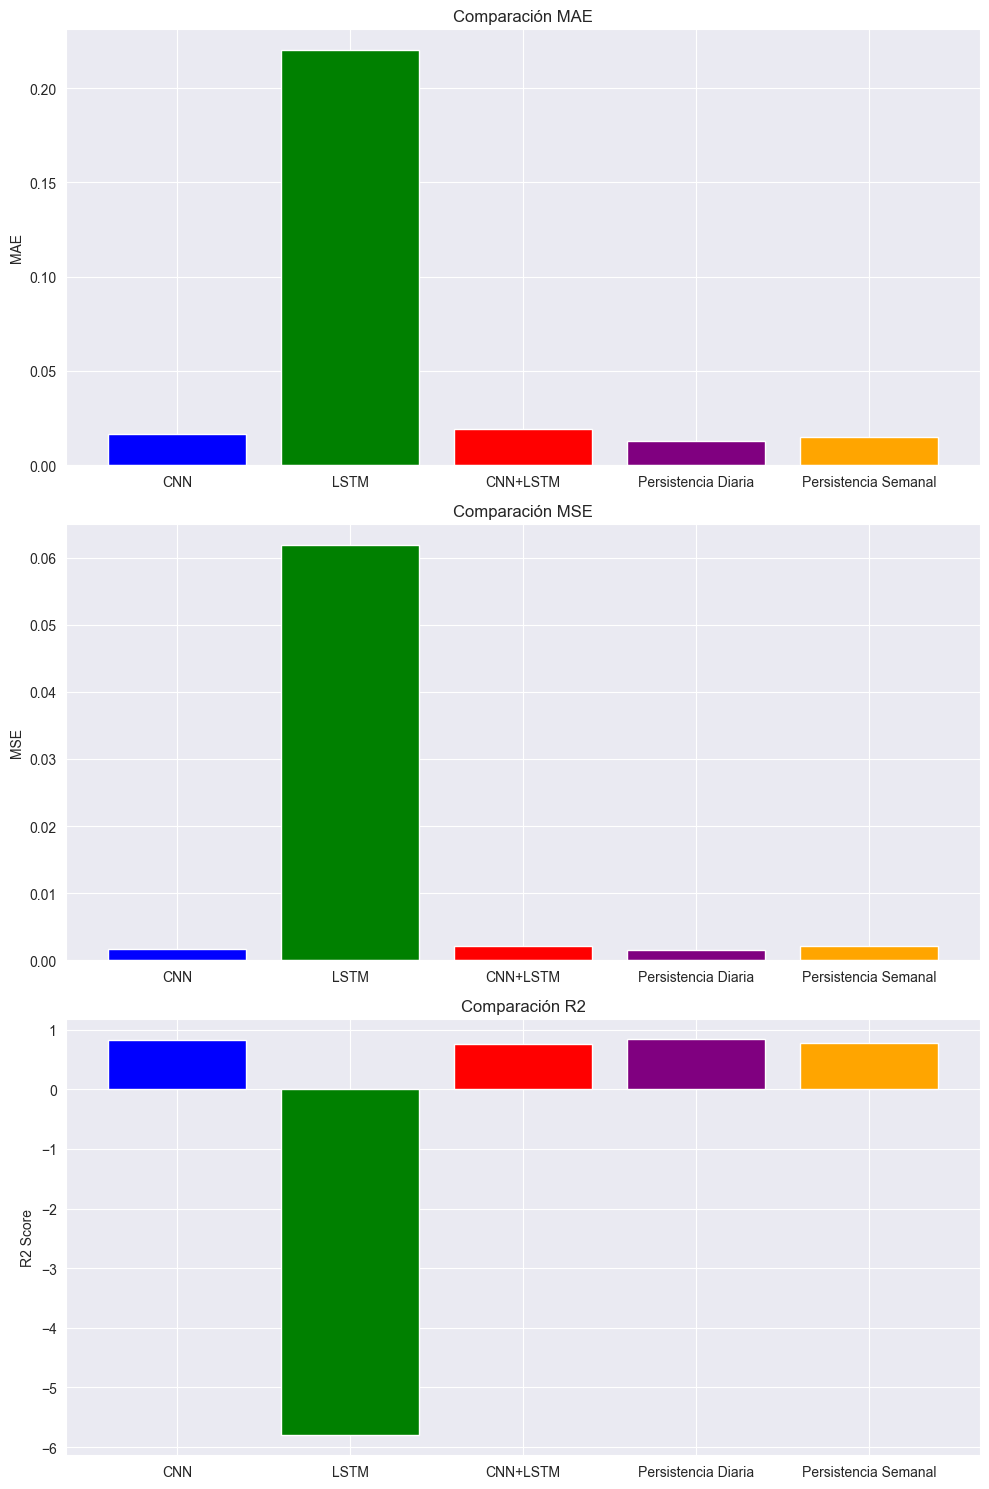

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import os
# 📌 Modelo CNN optimizado


def build_cnn_model(input_shape):
    model = models.Sequential([
        # 🔹 Primera capa convolucional
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # 🔹 Segunda capa convolucional
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # 🔹 Aplanar y capas densas
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),  # 🔹 Regularización para evitar sobreajuste
        layers.Dense(24)  # 🔹 Predicción de 24 valores
    ])

    # 🔹 Compilación del modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # 🔹 Tasa de aprendizaje más baja
        loss='mse',
        metrics=['mae', 'mse', tf.keras.metrics.R2Score()]
    )

    return model

def build_lstm_model(input_shape):
    model = models.Sequential([
        # 🔹 Primera capa LSTM
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(32, return_sequences=False),  # 🔹 Última capa LSTM sin secuencias

        # 🔹 Capas densas finales
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),  # 🔹 Regularización
        layers.Dense(24)  # 🔹 Predicción de 24 valores
    ])

    # 🔹 Compilar el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # 🔹 Misma tasa de aprendizaje que CNN
        loss='mse',
        metrics=['mae', 'mse', tf.keras.metrics.R2Score()]
    )

    return model


# 📌 Modelo CNN+LSTM optimizado
def build_cnn_lstm_model(input_shape):
    model = models.Sequential([
        # 🔹 Primera capa convolucional
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # 🔹 Segunda capa convolucional
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # 🔹 Aplanar y reestructurar para LSTM
        layers.Reshape((-1, 32)),  # 🔹 Convertir a secuencia para LSTM

        # 🔹 LSTM para modelar la dependencia temporal
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),

        # 🔹 Capas densas finales
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(24)  # 🔹 Predicción de 24 valores
    ])

    # 🔹 Compilar el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # 🔹 Misma tasa de aprendizaje
        loss='mse',
        metrics=['mae', 'mse', tf.keras.metrics.R2Score()]
    )

    return model


# 📌 Crear directorio para logs de TensorBoard

def get_tensorboard_callback(model_name):
    log_dir = f"logs/{model_name}"
    return callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# 🚀 Entrenar modelos
def train_model(model, train_dataset, val_dataset, callbacks, epochs=20, ):
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

# 📌 Evaluar en test
def evaluate_model(model, X_test, GT_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(GT_test, predictions)
    mse = mean_squared_error(GT_test, predictions)
    r2 = r2_score(GT_test, predictions)
    return mae, mse, r2

def persistence_daily(GT_test):
    """ Usa el consumo del día anterior como predicción.
    Si no hay fila anterior, usa la propia fila. """
    GT_pred = np.vstack([GT_test[0:1], GT_test[:-1]])  # Repite la primera fila si no hay anterior
    return GT_pred

def save_model(model, model_name, save_dir="../model"):
    """ Guarda el modelo entrenado en la carpeta especificada. """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model.save(os.path.join(save_dir, f"{model_name}.h5"))
    print(f"Modelo {model_name} guardado en {save_dir}")


def persistence_weekly(GT_test):
    """ Usa el consumo de la misma hora del día de la semana anterior como predicción.
    Si no hay semana anterior, usa el día anterior. """
    GT_pred = np.copy(GT_test)
    for i in range(GT_test.shape[0]):
        if i >= 7:
            GT_pred[i] = GT_test[i - 7]  # Usa la misma fila de hace 7 días
        else:
            GT_pred[i] = GT_test[i - 1]  # Usa el día anterior si no hay suficiente historia
    return GT_pred


# 📌 Ejecutar entrenamiento y evaluación
#cnn_model = build_cnn_model(X_train.shape[1:])
#lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2] * X_train.shape[3]))
cnn_lstm_model = build_cnn_lstm_model(X_train.shape[1:])


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

print("Entrenando CNN...")
# cnn_history = train_model(
#     cnn_model, train_dataset, val_dataset,
#     callbacks=[get_tensorboard_callback("CNN"),early_stop, reduce_lr],# 
#     epochs=20 
# )
#save_model(cnn_model, "cnn_model")


print("Entrenando LSTM...")
# X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
# X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
# lstm_history = train_model(
#     lstm_model, tf.data.Dataset.from_tensor_slices((X_train_lstm, GT_train)).batch(128),
#     tf.data.Dataset.from_tensor_slices((X_val_lstm, GT_val)).batch(128),
#     callbacks=[get_tensorboard_callback("LSTM"),early_stop, reduce_lr],
#     epochs=20
# )
# save_model(lstm_model, "lstm_model")


print("Entrenando CNN_LSTM...")
cnn_lstm_history = train_model(
    cnn_lstm_model, train_dataset, val_dataset,
    callbacks=[get_tensorboard_callback("CNN_LSTM"),early_stop, reduce_lr],# 
    epochs=20 
)
save_model(cnn_lstm_model, "cnn_lstm_model")

## Results _____
cnn_results = evaluate_model(cnn_model, X_test, GT_test)
lstm_results = evaluate_model(lstm_model, X_test_lstm, GT_test)
cnn_lstm_results = evaluate_model(cnn_lstm_model, X_test, GT_test)

# 📌 Evaluar modelos de persistencia
daily_predictions = persistence_daily (GT_test)

print ("GT_test")
weekly_predictions = persistence_weekly (GT_test)

daily_results = (
    mean_absolute_error(GT_test, daily_predictions),
    mean_squared_error(GT_test, daily_predictions),
    r2_score(GT_test, daily_predictions)
)

weekly_results = (
    mean_absolute_error(GT_test, weekly_predictions),
    mean_squared_error(GT_test, weekly_predictions),
    r2_score(GT_test, weekly_predictions)
)




In [ ]:
def plot_results(cnn, lstm, cnn_lstm, daily, weekly):
    labels = ['CNN', 'LSTM', 'CNN+LSTM', 'Persistencia Diaria', 'Persistencia Semanal']
    mae_values = [cnn[0], lstm[0], cnn_lstm[0], daily[0], weekly[0]]
    mse_values = [cnn[1], lstm[1], cnn_lstm[1], daily[1], weekly[1]]
    r2_values = [cnn[2], lstm[2], cnn_lstm[2], daily[2], weekly[2]]
    
    plt.figure(figsize=(10, 15))
    
    plt.subplot(3, 1, 1)
    plt.bar(labels, mae_values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title("Comparación MAE")
    plt.ylabel("MAE")
    
    plt.subplot(3, 1, 2)
    plt.bar(labels, mse_values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title("Comparación MSE")
    plt.ylabel("MSE")
    
    plt.subplot(3, 1, 3)
    plt.bar(labels, r2_values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title("Comparación R2")
    plt.ylabel("R2 Score")
    
    plt.tight_layout()
    plt.show()

# 📌 Mostrar gráficos de comparación
plot_results(cnn_results, lstm_results, cnn_lstm_results, daily_results, weekly_results)


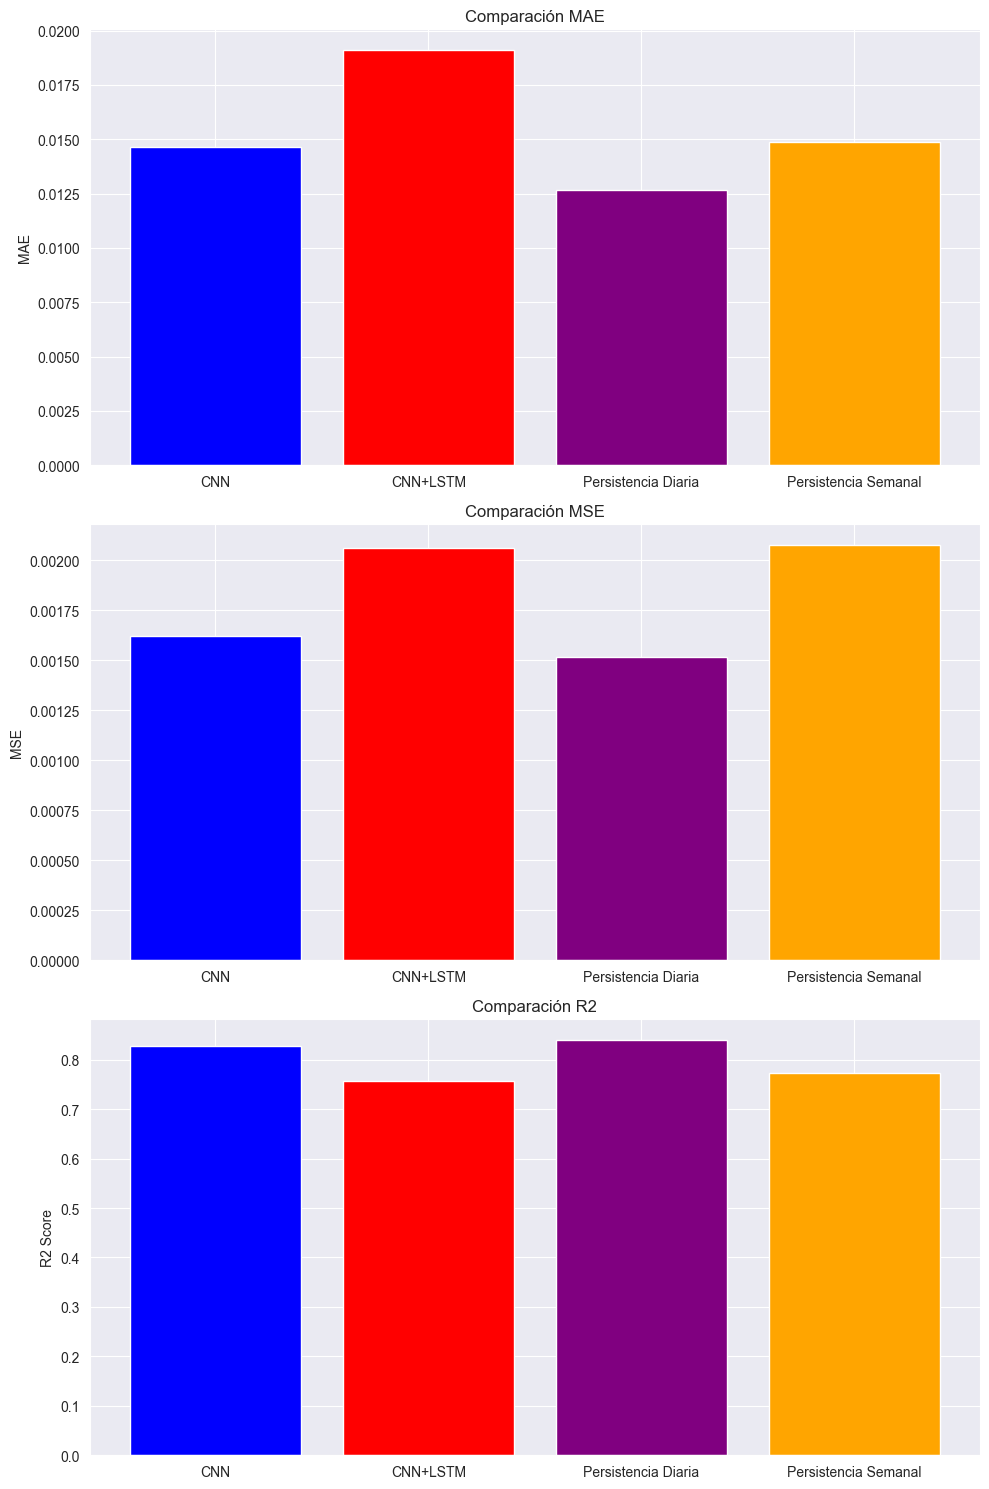

In [27]:
import matplotlib.pyplot as plt

def plot_results(cnn, cnn_lstm, daily, weekly):
    labels = ['CNN', 'CNN+LSTM', 'Persistencia Diaria', 'Persistencia Semanal']
    mae_values = [cnn[0], cnn_lstm[0], daily[0], weekly[0]]
    mse_values = [cnn[1], cnn_lstm[1], daily[1], weekly[1]]
    r2_values = [cnn[2], cnn_lstm[2], daily[2], weekly[2]]
    
    plt.figure(figsize=(10, 15))
    
    plt.subplot(3, 1, 1)
    plt.bar(labels, mae_values, color=['blue', 'red', 'purple', 'orange'])
    plt.title("Comparación MAE")
    plt.ylabel("MAE")
    
    plt.subplot(3, 1, 2)
    plt.bar(labels, mse_values, color=['blue', 'red', 'purple', 'orange'])
    plt.title("Comparación MSE")
    plt.ylabel("MSE")
    
    plt.subplot(3, 1, 3)
    plt.bar(labels, r2_values, color=['blue', 'red', 'purple', 'orange'])
    plt.title("Comparación R2")
    plt.ylabel("R2 Score")
    
    plt.tight_layout()
    plt.show()

# 📌 Mostrar gráficos de comparación sin LSTM
plot_results(cnn_results, cnn_lstm_results, daily_results, weekly_results)


In [26]:
cnn_results = evaluate_model(cnn_mejorado, X_test, GT_test)
cnn_results

/Users/fran/Developer/TimeSeriesImaging/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


(0.014659618027508259, 0.0016238844254985452, 0.8286924362182617)

celda para cargar un modelo entrenado

In [25]:

# 📌 Definir las métricas personalizadas
custom_objects = {
    "r2_score": tf.keras.metrics.R2Score(),
    "mse": tf.keras.losses.MeanSquaredError()
}

# 📌 Cargar el modelo incluyendo las métricas personalizadas
cnn_mejorado = tf.keras.models.load_model("../model/cnn_mejorado_model.h5", custom_objects=custom_objects,  compile=False)

lstm_model = tf.keras.models.load_model("../model/lstm_model.h5", custom_objects=custom_objects,  compile=False)



seguir entrenamiento de un modelo con buenos resultados

In [23]:
def get_tensorboard_callback(model_name):
    log_dir = f"logs/{model_name}"
    return callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


tf.config.run_functions_eagerly(True)

cnn_mejorado.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # 🔹 Ajuste fino con LR bajo
    loss='mse',
    metrics=['mae', 'mse', tf.keras.metrics.R2Score()]
)

# 📌 Callbacks para mejorar el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

tensorboard_cb = get_tensorboard_callback("CNN_FINE_TUNNING")  # Si usaste TensorBoard antes



# Volver a entrenar con más épocas
history = cnn_mejorado.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Puedes cambiar según necesites
    callbacks=[tensorboard_cb, early_stop, reduce_lr],
    verbose=1
)

save_model(cnn_mejorado, "cnn_mejorado_model")


Epoch 1/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - loss: 0.0038 - mae: 0.0401 - mse: 0.0038 - r2_score: -0.7126 - val_loss: 0.0010 - val_mae: 0.0148 - val_mse: 0.0010 - val_r2_score: 0.5112 - learning_rate: 5.0000e-04
Epoch 2/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - loss: 0.0021 - mae: 0.0266 - mse: 0.0021 - r2_score: 0.5038 - val_loss: 0.0011 - val_mae: 0.0175 - val_mse: 0.0011 - val_r2_score: 0.4621 - learning_rate: 5.0000e-04
Epoch 3/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 57s 56ms/step - loss: 0.0018 - mae: 0.0226 - mse: 0.0018 - r2_score: 0.5737 - val_loss: 0.0011 - val_mae: 0.0174 - val_mse: 0.0011 - val_r2_score: 0.4766 - learning_rate: 5.0000e-04
Epoch 4/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 57s 56ms/step - loss: 0.0018 - mae: 0.0213 - mse: 0.0018 - r2_score: 0.5919 - val_loss: 0.0010 - val_mae: 0.0155 - val_mse: 0.0010 - val_r2_score: 0.5190 - learning_rate: 5.0000e-04
Epoch 5/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step - loss: 0.0017 - mae: 0.0199 - mse: 0.0017 - r2

Modelo cnn_mejorado_model guardado en ../model


In [31]:
### Fine tuning 

for layer in modelo_cargado.layers[:-2]:  # Dejamos solo las últimas capas entrenables
    layer.trainable = False

modelo_cargado.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss='mse',
    metrics=['mae', 'mse', tf.keras.metrics.R2Score()]
)

history = modelo_cargado.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,  # Pocas épocas para ajuste fino
    callbacks=[tensorboard_cb, early_stop, reduce_lr],
    verbose=1
)


Epoch 1/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 0.0014 - mae: 0.0178 - mse: 0.0014 - r2_score: 0.6783 - val_loss: 8.4433e-04 - val_mae: 0.0116 - val_mse: 8.4433e-04 - val_r2_score: 0.6038 - learning_rate: 5.0000e-06
Epoch 2/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.0014 - mae: 0.0178 - mse: 0.0014 - r2_score: 0.6781 - val_loss: 8.4407e-04 - val_mae: 0.0116 - val_mse: 8.4407e-04 - val_r2_score: 0.6038 - learning_rate: 5.0000e-06
Epoch 3/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.0014 - mae: 0.0178 - mse: 0.0014 - r2_score: 0.6788 - val_loss: 8.4381e-04 - val_mae: 0.0116 - val_mse: 8.4381e-04 - val_r2_score: 0.6039 - learning_rate: 5.0000e-06
Epoch 4/5
  80/1011 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - loss: 0.0017 - mae: 0.0199 - mse: 0.0017 - r2_score: 0.5445

KeyboardInterrupt: 

In [27]:
import os
save_model(modelo_cargado, "cnn_mejorado_model")

Modelo cnn_mejorado_model guardado en ../model


celda para evaluar un modelo 

In [28]:
# 📌 Evaluar el modelo cargado
test_loss, test_mae, test_mse, test_r2 = modelo_cargado.evaluate(X_test, GT_test)

print(f"📌 Resultados en el Test Set:")
print(f"🔹 Test Loss (MSE): {test_loss:.6f}")
print(f"🔹 Test MAE: {test_mae:.6f}")
print(f"🔹 Test R2 Score: {test_r2:.6f}")


/Users/fran/Developer/TimeSeriesImaging/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


886/886 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0026 - mae: 0.0198 - mse: 0.0026 - r2_score: 0.6535
📌 Resultados en el Test Set:
🔹 Test Loss (MSE): 0.001967
🔹 Test MAE: 0.015584
🔹 Test R2 Score: 0.802544


celda para mostrar la comparativa entre los diferentes modelos para diferentes dias en test

19.56


/Users/fran/Developer/TimeSeriesImaging/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


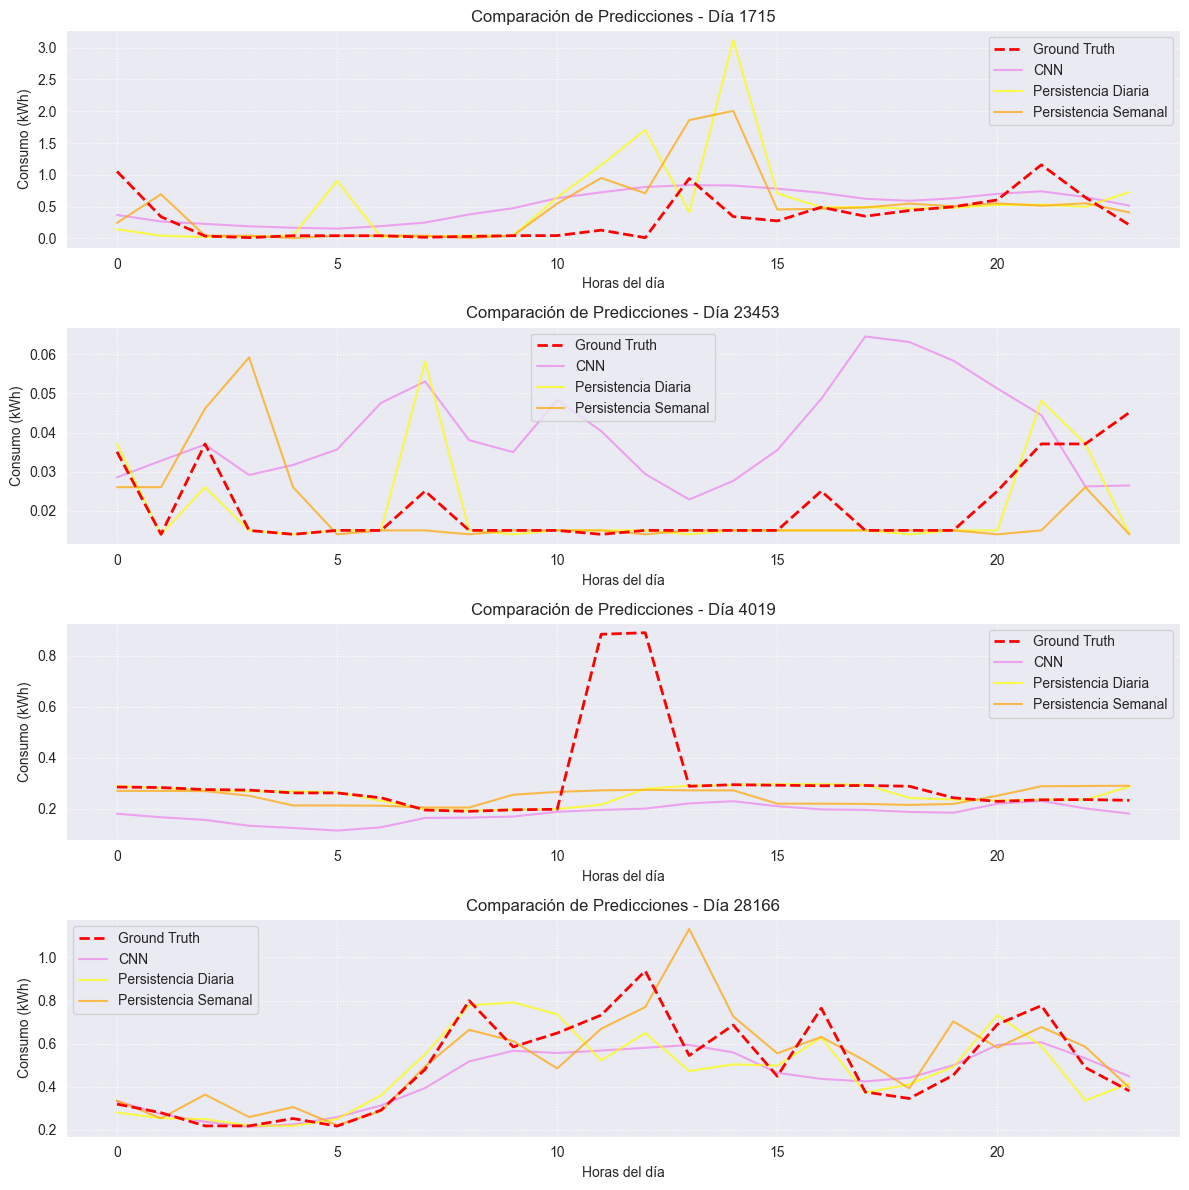

In [39]:

from sklearn.preprocessing import MinMaxScaler

def plot_predictions(GT_test, cnn_pred, daily_pred, weekly_pred, scaler):
    """ Muestra gráficos comparativos de las predicciones de cada modelo junto con el GT para 4 días. """
    GT_test = scaler.inverse_transform(GT_test)  # Desnormalizar GT
    cnn_pred = scaler.inverse_transform(cnn_pred)
    daily_pred = scaler.inverse_transform(daily_pred)
    weekly_pred = scaler.inverse_transform(weekly_pred)
    
    random_days = np.random.choice(range(GT_test.shape[0]), size=4, replace=False)
    
    plt.figure(figsize=(12, 12))
    for idx, i in enumerate(random_days):  # Mostrar predicciones para 4 días aleatorios
        plt.subplot(4, 1, idx+1)
        plt.plot(GT_test[i], label='Ground Truth', color='red', linestyle='dashed', linewidth=2, zorder=10)
        plt.plot(cnn_pred[i], label='CNN', color='violet', alpha=0.7)

        plt.plot(daily_pred[i], label='Persistencia Diaria', color='yellow', alpha=0.7)
        plt.plot(weekly_pred[i], label='Persistencia Semanal', color='orange', alpha=0.7)
        plt.legend()
        plt.title(f"Comparación de Predicciones - Día {i+1}")
        plt.xlabel("Horas del día")
        plt.ylabel("Consumo (kWh)")
        plt.grid(True, linestyle='dotted')
    
    plt.tight_layout()
    plt.show()
    
    # 📌 Obtener el mínimo y máximo común de todos los conjuntos de consumo
global_min = 0
global_max = data.loc[:, 'h1':'h24'].max().max() 

print (global_max)

# 📌 Crear el escalador para A y GT en el rango [0,1]
scaler_A_GT = MinMaxScaler(feature_range=(-1, 1))
scaler_A_GT.fit([[global_min], [global_max]])  # Ajustar con el mínimo y máximo global

plot_predictions(GT_test, cnn_mejorado.predict(X_test), daily_predictions, weekly_predictions, scaler_A_GT)

In [28]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        47,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,448 (247.84 KB)

 Trainable params: 63,448 (247.84 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
cnn_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 16)     │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 36, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 36, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,890 (542.54 KB)

 Trainable params: 46,296 (180.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,594 (361.70 KB)

Script pata probar predicciones de un solo modelo contra los datos reales de test


19.56
886/886 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


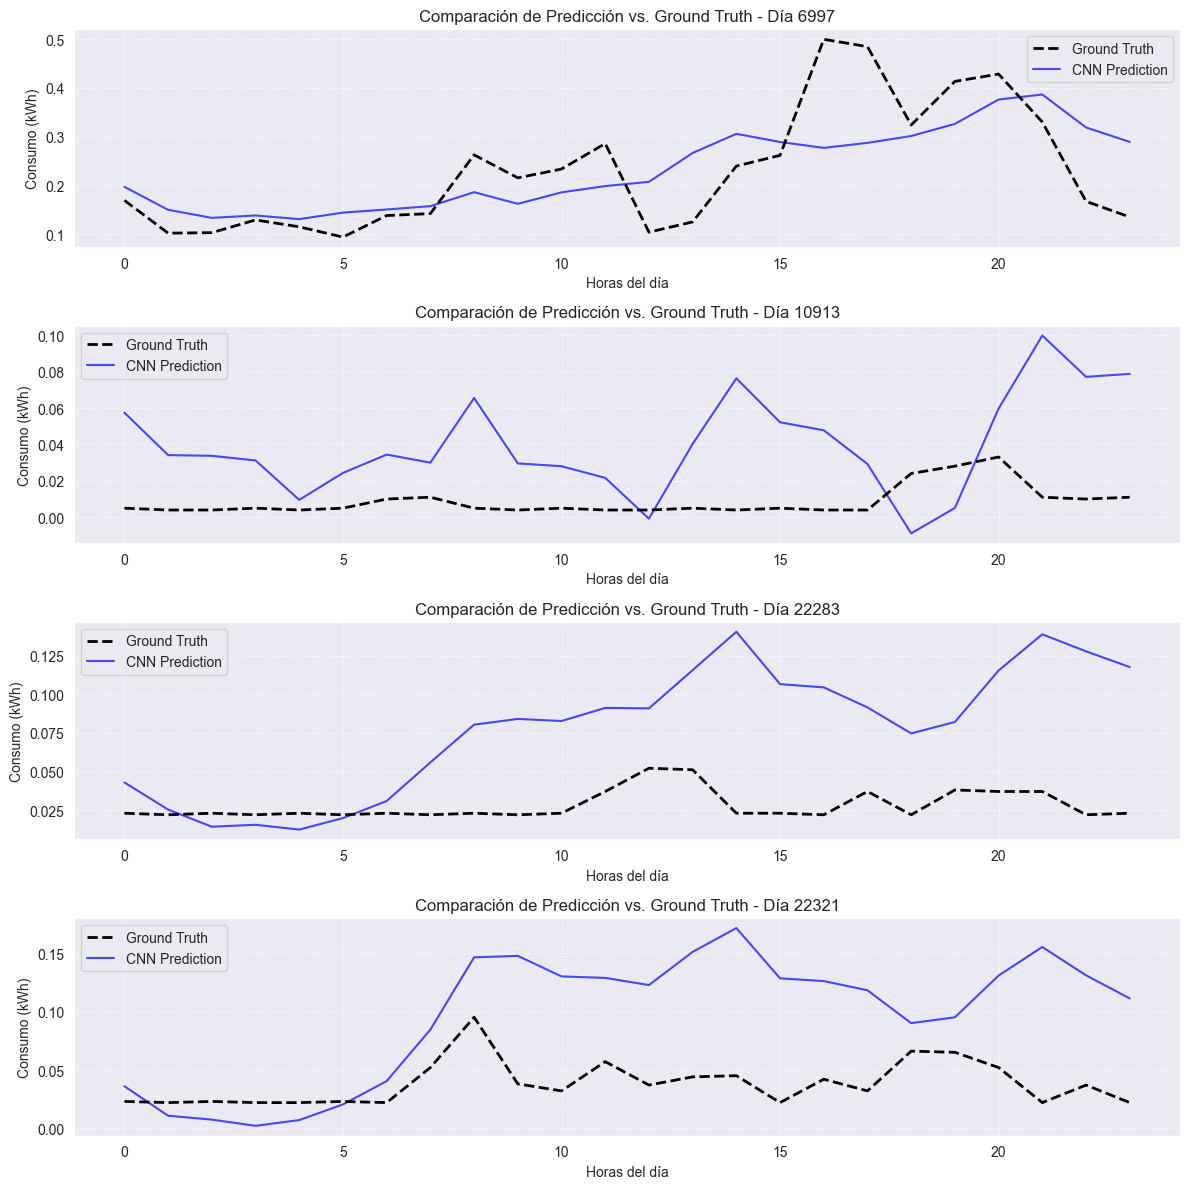

In [17]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def plot_predictions(GT_test, y_pred, scaler, num_dias=4):
    """
    Muestra gráficos comparativos de las predicciones del modelo CNN junto con el Ground Truth.
    
    - `GT_test`: Valores reales del test set.
    - `y_pred`: Predicciones del modelo en el test set.
    - `scaler`: Scaler usado para desnormalizar los datos.
    - `num_dias`: Número de días a mostrar en la gráfica.

    """

        
    # Desnormalizar los datos
    GT_test = scaler.inverse_transform(GT_test)
    y_pred = scaler.inverse_transform(y_pred)

    # Seleccionar días aleatorios para visualizar
    random_days = np.random.choice(range(GT_test.shape[0]), size=num_dias, replace=False)

    plt.figure(figsize=(12, num_dias * 3))

    for idx, i in enumerate(random_days):
        plt.subplot(num_dias, 1, idx + 1)
        plt.plot(GT_test[i], label='Ground Truth', color='black', linestyle='dashed', linewidth=2, zorder=10)
        plt.plot(y_pred[i], label='CNN Prediction', color='blue', alpha=0.7)
        plt.legend()
        plt.title(f"Comparación de Predicción vs. Ground Truth - Día {i+1}")
        plt.xlabel("Horas del día")
        plt.ylabel("Consumo (kWh)")
        plt.grid(True, linestyle='dotted')

    plt.tight_layout()
    plt.show()
    
    
    # 📌 Obtener el mínimo y máximo común de todos los conjuntos de consumo
global_min = 0
global_max = data.loc[:, 'h1':'h24'].max().max() 

print (global_max)

# 📌 Crear el escalador para A y GT en el rango [0,1]
scaler_A_GT = MinMaxScaler(feature_range=(-1, 1))
scaler_A_GT.fit([[global_min], [global_max]])  # Ajustar con el mínimo y máximo global


# 📌 Hacer predicciones y graficar resultados
y_pred_test = modelo_cargado.predict(X_test)  # Obtener predicciones del modelo
plot_predictions(GT_test, y_pred_test, scaler_A_GT, num_dias=4)  # Graficar


In [15]:
def persistence_daily(GT_test):
    """ Usa el consumo del día anterior como predicción.
    Si no hay fila anterior, usa la propia fila. """
    GT_pred = np.vstack([GT_test[0:1], GT_test[:-1]])  # Repite la primera fila si no hay anterior
    return GT_pred

def persistence_weekly(GT_test):
    """ Usa el consumo de la misma hora del día de la semana anterior como predicción.
    Si no hay semana anterior, usa el día anterior. """
    GT_pred = np.copy(GT_test)
    for i in range(GT_test.shape[0]):
        if i >= 7:
            GT_pred[i] = GT_test[i - 7]  # Usa la misma fila de hace 7 días
        else:
            GT_pred[i] = GT_test[i - 1]  # Usa el día anterior si no hay suficiente historia
    return GT_pred

In [22]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.021,0.022,0.023,0.021,0.022,0.021,0.021,0.021,0.022,0.021,...,0.022,0.021,0.022,0.021,0.505,1.155,0.062,0.022,0.021,0.023
1,0.021,0.021,0.024,0.021,0.021,0.024,0.022,0.02,0.023,0.022,...,0.023,0.021,0.021,0.023,0.021,0.02,0.022,0.022,0.02,0.023
2,0.022,0.021,0.022,0.023,0.021,0.023,0.022,0.02,0.023,0.022,...,0.023,0.021,0.02,0.023,0.021,0.02,0.022,0.022,0.021,0.022
3,0.022,0.02,0.023,0.022,0.02,0.022,0.022,0.021,0.022,0.021,...,0.022,0.021,0.021,0.033,0.3,1.193,0.129,0.021,0.02,0.023
4,0.021,0.021,0.023,0.022,0.02,0.023,0.022,0.02,0.022,0.021,...,0.022,0.021,0.02,0.022,0.309,1.161,0.032,0.021,0.02,0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28346,0.285,0.246,0.24,0.244,0.241,0.241,0.351,0.469,0.671,1.006,...,0.667,0.606,0.616,0.662,0.454,0.766,0.807,0.444,0.421,0.331
28347,0.36,0.28,0.245,0.214,0.374,0.212,0.32,0.686,1.277,0.977,...,0.725,0.531,0.725,0.589,0.529,0.586,0.696,0.636,0.5,0.414
28348,0.28,0.315,0.25,0.245,0.214,0.241,0.328,0.458,0.694,0.695,...,0.604,0.481,0.688,0.66,0.476,0.552,0.481,0.738,0.435,0.375
28349,0.393,0.243,0.245,0.281,0.266,0.246,0.327,0.308,0.515,0.632,...,0.449,0.578,0.386,0.445,0.779,0.737,0.513,0.532,0.392,0.478


In [23]:
df_test_norm

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.997846,-0.997744,-0.997641,-0.997846,-0.997744,-0.997846,-0.997846,-0.997846,-0.997744,-0.997846,...,-0.997744,-0.997846,-0.997744,-0.997846,-0.948205,-0.881538,-0.993641,-0.997744,-0.997846,-0.997641
1,-0.997846,-0.997846,-0.997538,-0.997846,-0.997846,-0.997538,-0.997744,-0.997949,-0.997641,-0.997744,...,-0.997641,-0.997846,-0.997846,-0.997641,-0.997846,-0.997949,-0.997744,-0.997744,-0.997949,-0.997641
2,-0.997744,-0.997846,-0.997744,-0.997641,-0.997846,-0.997641,-0.997744,-0.997949,-0.997641,-0.997744,...,-0.997641,-0.997846,-0.997949,-0.997641,-0.997846,-0.997949,-0.997744,-0.997744,-0.997846,-0.997744
3,-0.997744,-0.997949,-0.997641,-0.997744,-0.997949,-0.997744,-0.997744,-0.997846,-0.997744,-0.997846,...,-0.997744,-0.997846,-0.997846,-0.996615,-0.969231,-0.877641,-0.986769,-0.997846,-0.997949,-0.997641
4,-0.997846,-0.997846,-0.997641,-0.997744,-0.997949,-0.997641,-0.997744,-0.997949,-0.997744,-0.997846,...,-0.997744,-0.997846,-0.997949,-0.997744,-0.968308,-0.880923,-0.996718,-0.997846,-0.997949,-0.997641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28346,-0.970769,-0.974769,-0.975385,-0.974974,-0.975282,-0.975282,-0.964000,-0.951897,-0.931179,-0.896821,...,-0.931590,-0.937846,-0.936821,-0.932103,-0.953436,-0.921436,-0.917231,-0.954462,-0.956821,-0.966051
28347,-0.963077,-0.971282,-0.974872,-0.978051,-0.961641,-0.978256,-0.967179,-0.929641,-0.869026,-0.899795,...,-0.925641,-0.945538,-0.925641,-0.939590,-0.945744,-0.939897,-0.928615,-0.934769,-0.948718,-0.957538
28348,-0.971282,-0.967692,-0.974359,-0.974872,-0.978051,-0.975282,-0.966359,-0.953026,-0.928821,-0.928718,...,-0.938051,-0.950667,-0.929436,-0.932308,-0.951179,-0.943385,-0.950667,-0.924308,-0.955385,-0.961538
28349,-0.959692,-0.975077,-0.974872,-0.971179,-0.972718,-0.974769,-0.966462,-0.968410,-0.947179,-0.935179,...,-0.953949,-0.940718,-0.960410,-0.954359,-0.920103,-0.924410,-0.947385,-0.945436,-0.959795,-0.950974


In [24]:
GT_test

array([[0.021, 0.022, 0.023, ..., 0.022, 0.021, 0.023],
       [0.021, 0.021, 0.024, ..., 0.022, 0.02, 0.023],
       [0.022, 0.021, 0.022, ..., 0.022, 0.021, 0.022],
       ...,
       [0.28, 0.315, 0.25, ..., 0.738, 0.435, 0.375],
       [0.393, 0.243, 0.245, ..., 0.532, 0.392, 0.478],
       [0.301, 0.265, 0.281, ..., 0.409, 0.416, 0.375]], dtype=object)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
GT_test_norm = df_test_norm.to_numpy()
GT_test = df_test_norm.to_numpy()
persist_diaria_test_sin_normalizar = persistence_daily(GT_test)
persist_diadia_test_normalizado = persistence_daily(GT_test_norm)
persist_semanal_test_sin_normalizar = persistence_weekly(GT_test)
persist_semanal_test_normalizado = persistence_weekly(GT_test_norm)
daily_results_norm = (
    mean_absolute_error(GT_test_norm, persist_diadia_test_normalizado),
    mean_squared_error(GT_test_norm, persist_diadia_test_normalizado),
)

weekly_results_norm = (
    mean_absolute_error(GT_test_norm, persist_semanal_test_normalizado),
    mean_squared_error(GT_test_norm, persist_semanal_test_normalizado),
)
daily_results= (
    mean_absolute_error(GT_test, persist_diaria_test_sin_normalizar),
    mean_squared_error(GT_test, persist_diaria_test_sin_normalizar),
)

weekly_results = (
    mean_absolute_error(GT_test, persist_semanal_test_sin_normalizar),
    mean_squared_error(GT_test, persist_semanal_test_sin_normalizar),
)

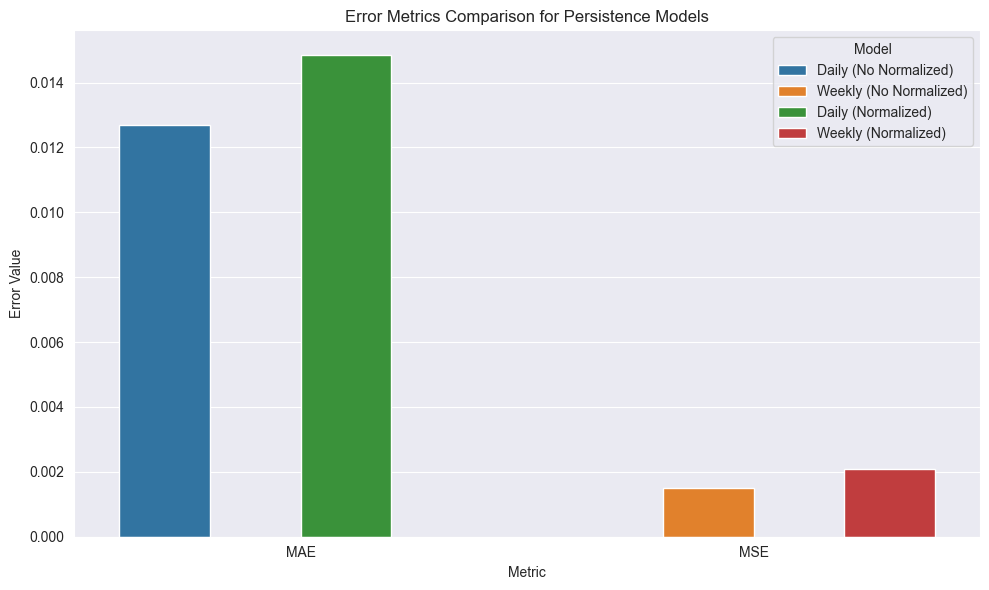

In [34]:
metrics = ['MAE', 'MSE']
import seaborn as sns

data = {
    'Metric': np.tile(metrics, 4),  # Repetimos las métricas para cada caso
    'Score': np.concatenate([
        daily_results, weekly_results, daily_results_norm, weekly_results_norm
    ]),  # Todos los resultados de los modelos
    'Model': ['Daily (No Normalized)', 'Weekly (No Normalized)', 'Daily (Normalized)', 'Weekly (Normalized)'] * 2  # Solo 2 métricas
}

df_results = pd.DataFrame(data)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Metric', y='Score', hue='Model')

# Personalizar el gráfico
plt.title('Error Metrics Comparison for Persistence Models')
plt.ylabel('Error Value')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.tight_layout()

# Mostrar gráfico
plt.show()